In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
from math import radians, cos, sin, atan, degrees, sqrt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import random
from IPython.display import display, HTML, Math, Latex
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

In [2]:
# Read the CSV file. This is an example of required data. from High Island Block 24-L, offshore Gulf of Mexico
df = pd.read_csv('Input_Data_Example_FaultReactivation_InjectionPressureWindow_default.csv')
df

,Fault ID,Origin_Easting,Origin_Northing,End_Easting,End_Northing,Average_Depth,dip,dip_direction,strike,Pp,Sv,SH_max,Sh_min
0,F1a,308,16772,3338,16106,7250,53,SW,102.396596,3190,7250,5727.5,5510
1,F1b,3338,16106,8116,16556,7150,53,S,84.619659,3146,7150,5648.5,5434
2,F1c,8116,16556,12481,17589,7050,53,SE,76.685609,3102,7050,5569.5,5358
3,F1d,12481,17589,17478,21367,7300,53,SE,52.908764,3212,7300,5767.0,5548
4,F2,5535,14938,7824,16209,7500,52,SE,60.958149,3300,7500,5925.0,5700
5,F3,15162,12008,17994,14322,7800,55,SE,50.748072,3432,7800,6162.0,5928
6,F4a,713,13675,3623,14480,7400,56,SE,74.536837,3256,7400,5846.0,5624
7,F4b,3623,14480,6489,14394,7400,56,S,91.718757,3256,7400,5846.0,5624
8,F4c,6489,14394,10095,12178,7500,56,SW,121.572028,3300,7500,5925.0,5700
9,F4d,10095,12178,14704,11738,7700,56,S,95.453238,3388,7700,6083.0,5852


<IPython.core.display.Javascript object>


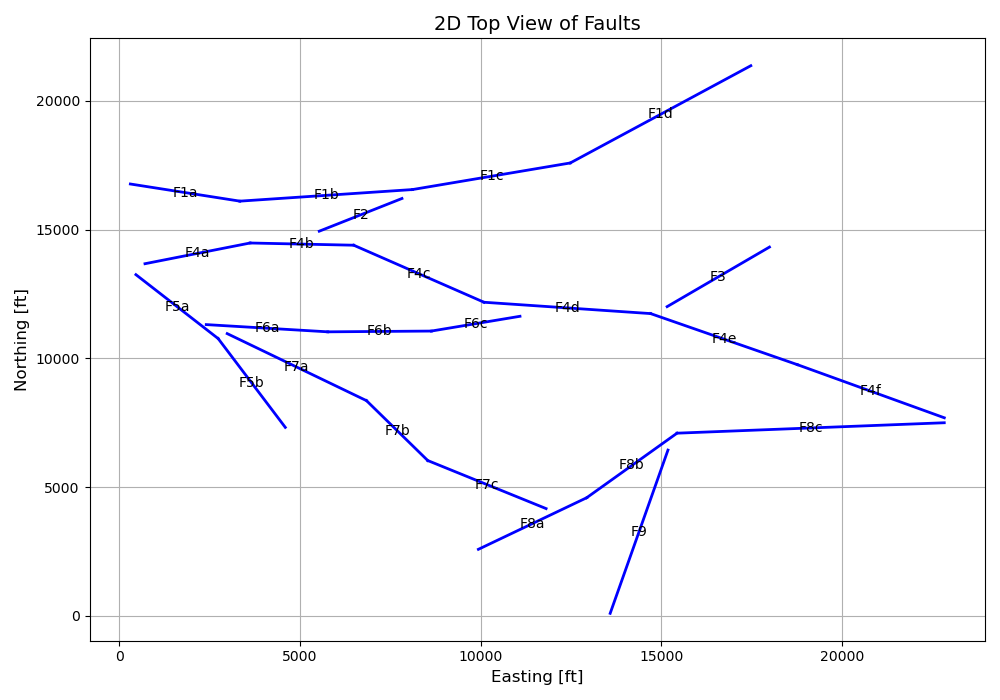

In [3]:
# Function to plot faults as straight lines in a 2D top view map with Fault IDs
def plot_faults_2d_top_view_with_ids(df):
    plt.figure(figsize=(10, 7))
    
    for index, row in df.iterrows():
        x_values = [row['Origin_Easting'], row['End_Easting']]
        y_values = [row['Origin_Northing'], row['End_Northing']]
        
        plt.plot(x_values, y_values, color='blue', linewidth=2)
        
        # Calculate midpoint for annotation
        mid_x = (x_values[0] + x_values[1]) / 2
        mid_y = (y_values[0] + y_values[1]) / 2
        plt.annotate(row['Fault ID'], (mid_x, mid_y), fontsize=10, ha='center', va='center')
    
    plt.title('2D Top View of Faults', fontsize=14)
    plt.xlabel('Easting [ft]', fontsize=12)
    plt.ylabel('Northing [ft]', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot the faults with IDs
plot_faults_2d_top_view_with_ids(df)

## Calculate the stress tensor for each fault. The direction of 𝑆ℎ𝑚𝑖𝑛 is N-S.

In [4]:
# Calculate S1, S2, and S3
df['S1'] = df[['Sv', 'SH_max', 'Sh_min']].max(axis=1)
df['S3'] = df[['Sv', 'SH_max', 'Sh_min']].min(axis=1)
df['S2'] = df['Sv'] + df['SH_max'] + df['Sh_min'] - df['S1'] - df['S3']

# Initialize lists for Sn, SigmaN, and tau
Sn = []
SigmaN = []
tau = []

# Extract necessary columns
Pp = df['Pp'].values
S1 = df['S1'].values
S2 = df['S2'].values
S3 = df['S3'].values
dip = df['dip'].values
strike = df['strike'].values

# Define constants
alpha_deg = 0
beta_deg = 90
gamma_deg = 0
alpha = np.radians(alpha_deg)
beta = np.radians(beta_deg)
gamma = np.radians(gamma_deg)

# Calculate the change of basis matrix
R_pg = np.array([
    [np.cos(alpha) * np.cos(beta), np.sin(alpha) * np.cos(beta), -np.sin(beta)],
    [np.cos(alpha) * np.sin(beta) * np.sin(gamma) - np.sin(alpha) * np.cos(gamma), 
     np.sin(alpha) * np.sin(beta) * np.sin(gamma) + np.cos(alpha) * np.cos(gamma), 
     np.cos(beta) * np.sin(gamma)],
    [np.cos(alpha) * np.sin(beta) * np.cos(gamma) + np.sin(alpha) * np.sin(gamma), 
     np.sin(alpha) * np.sin(beta) * np.cos(gamma) - np.cos(alpha) * np.sin(gamma), 
     np.cos(beta) * np.cos(gamma)]
])

R_pgT = R_pg.T

# Calculate stress tensor for each fault
for i in range(S1.shape[0]):
    Sp = np.array([[S1[i], 0, 0], [0, S2[i], 0], [0, 0, S3[i]]])
    Sg = R_pgT.dot(Sp).dot(R_pg)
    Nni = -np.sin(np.radians(strike[i])) * np.sin(np.radians(dip[i]))
    Nnj = np.cos(np.radians(strike[i])) * np.sin(np.radians(dip[i]))
    Nnk = -np.cos(np.radians(dip[i]))
    Nn = np.array([[Nni], [Nnj], [Nnk]])
    t = Sg.dot(Nn)
    Sn_value = t[0, 0] * Nni + t[1, 0] * Nnj + t[2, 0] * Nnk
    SigmaN_value = Sn_value - Pp[i]
    tau_value = np.sqrt((np.linalg.norm(t)) ** 2 - (Sn_value) ** 2)
    Sn.append(Sn_value)
    SigmaN.append(SigmaN_value)
    tau.append(tau_value)

df['Sn'] = Sn
df['SigmaN'] = SigmaN
df['tau'] = tau
df['Ratio'] = df['tau'] / df['SigmaN']
df['SigmaN/SigmaV'] = df['SigmaN'] / (df['Sv'] - df['Pp'])
df['tau/SigmaV'] = df['tau'] / (df['Sv'] - df['Pp'])

# Display the modified DataFrame
df.head()

,Fault ID,Origin_Easting,Origin_Northing,End_Easting,End_Northing,Average_Depth,dip,dip_direction,strike,Pp,...,Sh_min,S1,S3,S2,Sn,SigmaN,tau,Ratio,SigmaN/SigmaV,tau/SigmaV
0,F1a,308,16772,3338,16106,7250,53,SW,102.396596,3190,...,5510,7250.0,5510.0,5727.5,6146.588854,2956.588854,832.277211,0.281499,0.728224,0.204994
1,F1b,3338,16106,8116,16556,7150,53,S,84.619659,3146,...,5434,7150.0,5434.0,5648.5,6056.706028,2910.706028,824.011301,0.283097,0.726950,0.205797
2,F1c,8116,16556,12481,17589,7050,53,SE,76.685609,3102,...,5358,7050.0,5358.0,5569.5,5977.965201,2875.965201,808.722557,0.281200,0.728461,0.204844
3,F1d,12481,17589,17478,21367,7300,53,SE,52.908764,3212,...,5548,7300.0,5548.0,5767.0,6233.345900,3021.345900,808.173335,0.267488,0.739077,0.197694
4,F2,5535,14938,7824,16209,7500,52,SE,60.958149,3300,...,5700,7500.0,5700.0,5925.0,6415.195830,3115.195830,850.875842,0.273137,0.741713,0.202589


## Calculate the effective normal stress 𝜎_𝑛 and shear stress 𝜏 on each fault and plot the results together in a normalized 3D Mohr circle with x-axis ( 𝜎𝑛/𝜎𝑣 ) and y-axis ( 𝜏/𝜎𝑣 ). Assume hydrostatic pore pressure d 𝑃𝑝/ d 𝑧=0.44 psi/ft.

<IPython.core.display.Javascript object>


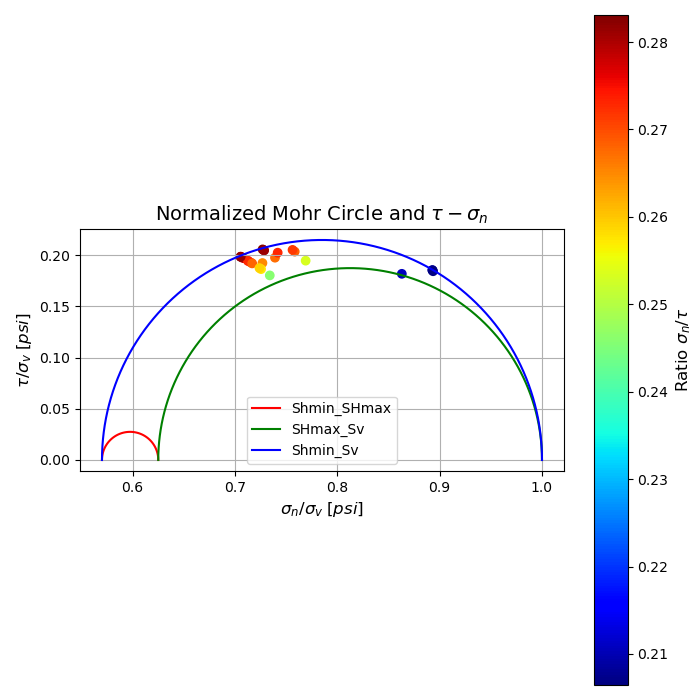

In [5]:
# Plotting function for Mohr's circle
def plot_mohr_circle(sig3, sig2, sig1):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    angles = np.linspace(0, np.pi, 100)
    
    circle1_x = (sig2 - sig3) / 2 * np.cos(angles) + (sig3 + (sig2 - sig3) / 2)
    circle1_y = (sig2 - sig3) / 2 * np.sin(angles)
    circle2_x = (sig1 - sig2) / 2 * np.cos(angles) + (sig2 + (sig1 - sig2) / 2)
    circle2_y = (sig1 - sig2) / 2 * np.sin(angles)
    circle3_x = (sig1 - sig3) / 2 * np.cos(angles) + (sig3 + (sig1 - sig3) / 2)
    circle3_y = (sig1 - sig3) / 2 * np.sin(angles)
    
    ax.plot(circle1_x, circle1_y, 'r', label='Shmin_SHmax')
    ax.plot(circle2_x, circle2_y, 'g', label='SHmax_Sv')
    ax.plot(circle3_x, circle3_y, 'b', label='Shmin_Sv')
    
    ax.set_xlabel(r'$\sigma_n / \sigma_v$', fontsize=12)
    ax.set_ylabel(r'$\tau / \sigma_v$', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the Mohr's circle and scatter plot of normalized values
plot_mohr_circle(0.57, 0.625, 1)

c1 = df['tau/SigmaV'] / df['SigmaN/SigmaV']
plt.scatter(df['SigmaN/SigmaV'], df['tau/SigmaV'], c=c1, marker='o', cmap=cm.jet)
cbar = plt.colorbar()
cbar.set_label('Ratio ' r'$\sigma_n / \tau$', fontsize=12)
plt.title('Normalized Mohr Circle and ' r'$\tau  - \sigma_n $', fontsize=14)
plt.xlabel(r'$\sigma_n / \sigma_v \; [psi]$', fontsize=12)
plt.ylabel(r'$\tau / \sigma_v \; [psi]$', fontsize=12)
plt.grid(True)
plt.show()

## Are there any faults prone to reactivation (assume friction coefficient 𝜇=0.6 )? If yes, what faults are those?

<IPython.core.display.Javascript object>


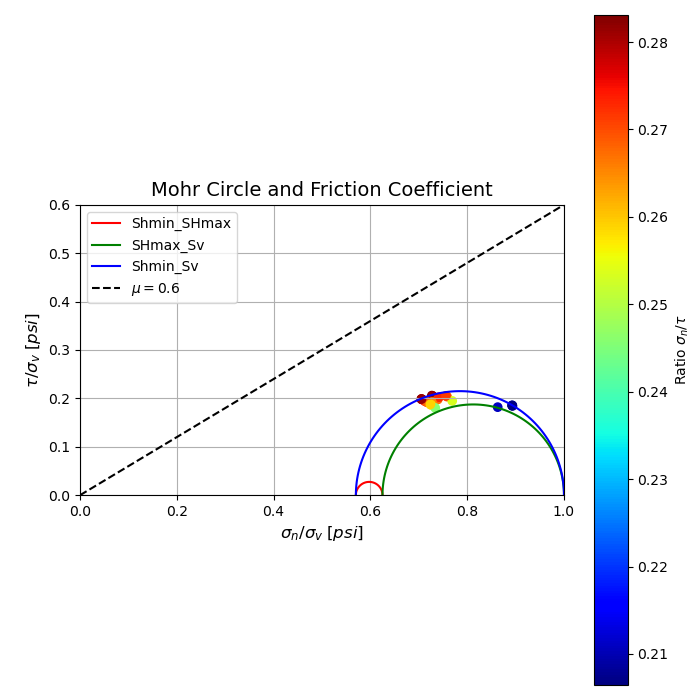

No faults are prone to reactivation with μ=0.6.


In [6]:
# Plotting function for Mohr's circle
def plot_mohr_circle(sig3, sig2, sig1):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    angles = np.linspace(0, np.pi, 100)
    
    circle1_x = (sig2 - sig3) / 2 * np.cos(angles) + (sig3 + (sig2 - sig3) / 2)
    circle1_y = (sig2 - sig3) / 2 * np.sin(angles)
    circle2_x = (sig1 - sig2) / 2 * np.cos(angles) + (sig2 + (sig1 - sig2) / 2)
    circle2_y = (sig1 - sig2) / 2 * np.sin(angles)
    circle3_x = (sig1 - sig3) / 2 * np.cos(angles) + (sig3 + (sig1 - sig3) / 2)
    circle3_y = (sig1 - sig3) / 2 * np.sin(angles)
    
    ax.plot(circle1_x, circle1_y, 'r', label='Shmin_SHmax')
    ax.plot(circle2_x, circle2_y, 'g', label='SHmax_Sv')
    ax.plot(circle3_x, circle3_y, 'b', label='Shmin_Sv')
    
    ax.set_xlabel(r'$\sigma_n / \sigma_v$', fontsize=12)
    ax.set_ylabel(r'$\tau / \sigma_v$', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the Mohr's circle
plot_mohr_circle(0.57, 0.625, 1)

# Determine the ratio for coloring the scatter plot
c1 = df['tau/SigmaV'] / df['SigmaN/SigmaV']

# Plot normalized normal and shear stresses for each fault
plt.scatter(df['SigmaN/SigmaV'], df['tau/SigmaV'], c=c1, marker='o', cmap=cm.jet)
plt.title('Mohr Circle and Friction Coefficient', fontsize=14)

# Plot shear failure line
sigma_range = np.linspace(0, 1, 100)
failure_line = sigma_range * 0.6
plt.plot(sigma_range, failure_line, 'k--', label=r'$\mu=0.6$')

# Configure plot
plt.xlim([0, 1])
plt.ylim([0, 0.6])
plt.xlabel(r'$\sigma_n / \sigma_v \; [psi]$', fontsize=12)
plt.ylabel(r'$\tau / \sigma_v \; [psi]$', fontsize=12)
plt.grid(True)
plt.legend()
plt.colorbar(label='Ratio ' r'$\sigma_n / \tau$')
plt.show()

# Check for faults prone to reactivation
reactivation_prone_faults = df[df['tau/SigmaV'] > df['SigmaN/SigmaV'] * 0.6]
if not reactivation_prone_faults.empty:
    print("Faults prone to reactivation:")
    print(reactivation_prone_faults[['Fault ID', 'tau', 'SigmaN', 'tau/SigmaV', 'SigmaN/SigmaV']])
else:
    print("No faults are prone to reactivation with μ=0.6.")

## Assuming that fluid injection would shift Mohr circles to lower $\sigma_n$ values without change of $\tau$ values (circle moves to the left without change of diameter - conservative assumption), what is the maximum allowable pressure increase without causing fault reactivation?

In [7]:
# Conversion factor from psi to MPa
psi_to_mpa = 0.00689476

# Calculate the maximum allowable pressure increase without causing fault reactivation
delta_sigma = 0.36715  # Example delta for pressure increase

# Define original and shifted stresses
df2 = pd.DataFrame({
    'sig3': [0.57, 0.57 - delta_sigma],
    'sig2': [0.625, 0.625 - delta_sigma],
    'sig1': [1, 1 - delta_sigma]
})

# Determine the maximum allowable pressure increase for each fault
df['Pressure_Increase_psi'] = df['SigmaN'] * 0.6 - df['tau']
df['Pressure_Increase_psi'] = df['Pressure_Increase_psi'].round(0)
df['Pressure_Increase_MPa'] = df['Pressure_Increase_psi'] * psi_to_mpa
df['Pressure_Increase_MPa'] = df['Pressure_Increase_MPa'].round(2)
max_pressure_increase_psi = df['Pressure_Increase_psi'].min()
max_pressure_increase_mpa = df['Pressure_Increase_MPa'].min()

# Print maximum allowable pressure increase for each fault
for index, row in df.iterrows():
    print(f"Fault ID: {row['Fault ID']}, Maximum allowable pressure increase: {row['Pressure_Increase_psi']:.0f} psi / {row['Pressure_Increase_MPa']:.2f} MPa")


Fault ID: F1a, Maximum allowable pressure increase: 942 psi / 6.49 MPa
Fault ID: F1b, Maximum allowable pressure increase: 922 psi / 6.36 MPa
Fault ID: F1c, Maximum allowable pressure increase: 917 psi / 6.32 MPa
Fault ID: F1d, Maximum allowable pressure increase: 1005 psi / 6.93 MPa
Fault ID: F2, Maximum allowable pressure increase: 1018 psi / 7.02 MPa
Fault ID: F3, Maximum allowable pressure increase: 1064 psi / 7.34 MPa
Fault ID: F4a, Maximum allowable pressure increase: 943 psi / 6.50 MPa
Fault ID: F4b, Maximum allowable pressure increase: 931 psi / 6.42 MPa
Fault ID: F4c, Maximum allowable pressure increase: 993 psi / 6.85 MPa
Fault ID: F4d, Maximum allowable pressure increase: 970 psi / 6.69 MPa
Fault ID: F4e, Maximum allowable pressure increase: 1082 psi / 7.46 MPa
Fault ID: F4f, Maximum allowable pressure increase: 1091 psi / 7.52 MPa
Fault ID: F5a, Maximum allowable pressure increase: 1114 psi / 7.68 MPa
Fault ID: F5b, Maximum allowable pressure increase: 1194 psi / 8.23 MPa
F

## Plot the faults as straight lines in a 2D top view map and identify faults closer to reactivation. Suggestion: color segments according to the value of 𝜏/𝜎𝑛 where red is high likelihood for reactivation and blue is low likelihood for reactivation.

<IPython.core.display.Javascript object>


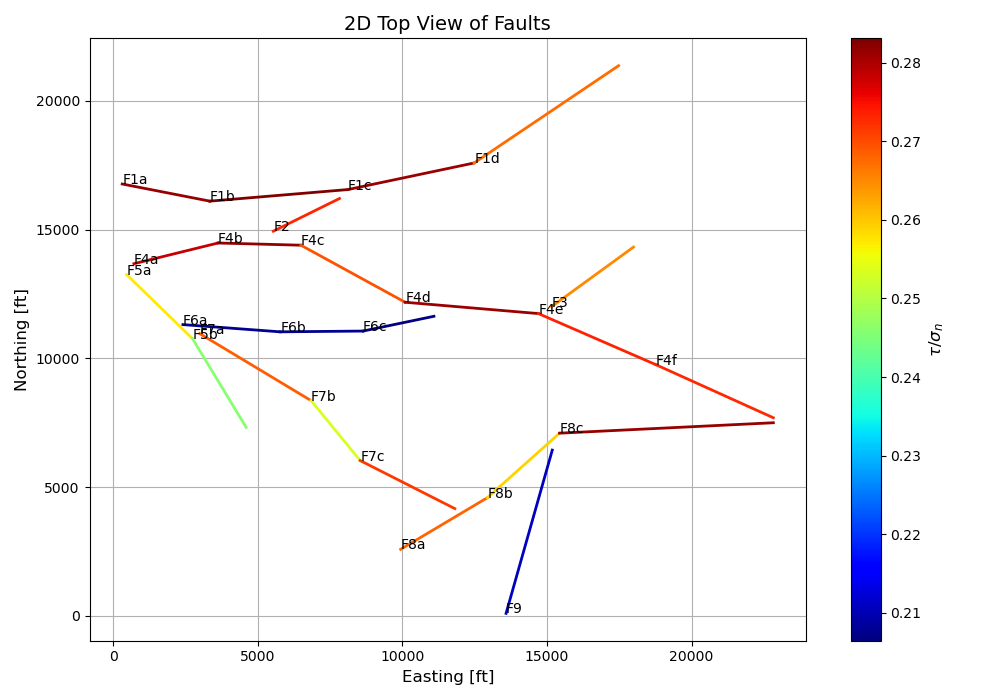

In [8]:
# Function to plot faults as straight lines in a 2D top view map
def plot_faults_2d_top_view(df):
    plt.figure(figsize=(10, 7))
    
    # Normalize the tau/SigmaN values for color mapping
    tau_sigma_ratio = df['tau'] / df['SigmaN']
    norm = plt.Normalize(tau_sigma_ratio.min(), tau_sigma_ratio.max())
    cmap = cm.get_cmap('jet')
    
    for index, row in df.iterrows():
        x_values = [row['Origin_Easting'], row['End_Easting']]
        y_values = [row['Origin_Northing'], row['End_Northing']]
        color_value = cmap(norm(row['tau'] / row['SigmaN']))
        
        plt.plot(x_values, y_values, color=color_value, linewidth=2)
        plt.annotate(row['Fault ID'], (x_values[0], y_values[0]), fontsize=10)
    
    plt.title('2D Top View of Faults', fontsize=14)
    plt.xlabel('Easting [ft]', fontsize=12)
    plt.ylabel('Northing [ft]', fontsize=12)
    plt.grid(True)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical')
    cbar.set_label(r'$\tau / \sigma_n$', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Call the function to plot the faults
plot_faults_2d_top_view(df)

## The End